# Data Analytics Fall 2025 &mdash; Exercises 4

### XXXXX XXXXX (last modified: Tue 21 Oct)

- Five problems + round 3 peer review
- Theme: time series
- Keep your originals up to date by running the code cell below:

In [ ]:
import os
os.system('/usr/bin/bash /home/varpha/dan/config.sh');

## Plan for calendar week 43

- overview on Tuesday (Teams)
- deeper during the weekend (face-to-face).

No Teams session on Tue Oct 28 (after the weekend).


## Round 3 peer review

As before. Please ask on the channel or by email if you have issues.

## `I used AI in this homework as a consultant and debug partner. I checked interpretations, clarified the meaning of some parts, and received specific suggestions`

## Problem 1. Shifting
The file

    public/exrc_04/data/windmill_temperature.csv
  
contains a temperature timeseries measured from the top of a windmill at about 200 meters high.

The file

    public/exrc_04/data/fmi_temperature.csv
    
contains the corresponding [fmi](en.ilmatieteenlaitos.fi) temperature timeseries measured from a nearby station at 2 meters high, and about 30km away from the windmill.

The windmill operator did not include any metadata, e.g. what is the timezone in the windmill data. Your task is to find out what is the difference (if any) in the timezones.

**Note: This is not an easy task, and there is not a best method (unless we agree having found one)!**

In [167]:
import pandas as pd

path_top = '~/dan/public/exrc_04/data/windmill_temperature.csv'
df_top = pd.read_csv(path_top, index_col=0)
df_top.head()

,T_NacOutAir.actual
t,
2018 01 01 00:00:00,-1.9
2018 01 01 00:10:00,-1.9
2018 01 01 00:20:00,-2.0
2018 01 01 00:30:00,-2.1
2018 01 01 00:40:00,-2.3


In [168]:
# Let's convert the timestamp to datetime and assignt it as index
df_top.index = pd.to_datetime(df_top.index, format='%Y %m %d %H:%M:%S')

df_top.head()

,T_NacOutAir.actual
t,
2018-01-01 00:00:00,-1.9
2018-01-01 00:10:00,-1.9
2018-01-01 00:20:00,-2.0
2018-01-01 00:30:00,-2.1
2018-01-01 00:40:00,-2.3


In [169]:
path_nearby = '~/dan/public/exrc_04/data/fmi_temperature.csv'
df_nearby = pd.read_csv(path_nearby)
df_nearby.head()

,Year,Month,Day,Time,Timezone,Temperature(degC)
0,2018,1,1,00:00,UTC,-2.4
1,2018,1,1,00:10,UTC,-2.2
2,2018,1,1,00:20,UTC,-1.7
3,2018,1,1,00:30,UTC,-1.4
4,2018,1,1,00:40,UTC,-1.3


In [170]:
# Let's construct the timestamp and assign it as dfs'
df_nearby.index = pd.to_datetime(
    df_nearby['Year'].astype(str) + '-' + 
    df_nearby['Month'].astype(str) + "-" + 
    df_nearby['Day'].astype(str) + ' ' + 
    df_nearby['Time'].astype(str)
)

# df_nearby.index = df_nearby.index.tz_localize('UTC')


df_nearby = df_nearby.drop(['Year', 'Month', 'Day', 'Time', 'Timezone'], axis=1)
df_nearby.head()

,Temperature(degC)
2018-01-01 00:00:00,-2.4
2018-01-01 00:10:00,-2.2
2018-01-01 00:20:00,-1.7
2018-01-01 00:30:00,-1.4
2018-01-01 00:40:00,-1.3


Now we have two dfs, df_nearby is has UTC timezone, while df_top does not have any
When zone is not known the main question sounds like:

`On how many hours we need to shift df_top timestamps, so that they will 
describe the exact same moments as df_nearby`

The logic to determine the timesone can be like:

1. Both timeserieses is air temperature almost in the same place and time.
2. We could pick the time shift when correlation between them is highest.

In [171]:
series_top = (
    df_top['T_NacOutAir.actual']
    .astype(float)
    .sort_index()
)

# for the df_nearby we need to clean the Temperature(degC) column,
# Otherwise we will have the ValueError: could not convert string to float: '-' error next
df_nearby['Temperature(degC)'] = pd.to_numeric(df_nearby['Temperature(degC)'], errors='coerce')

series_nearby = (
    df_nearby['Temperature(degC)']
    .astype(float)
    .sort_index()
)

series_top.head(), series_nearby.head()

(t
 2018-01-01 00:00:00   -1.9
 2018-01-01 00:10:00   -1.9
 2018-01-01 00:20:00   -2.0
 2018-01-01 00:30:00   -2.1
 2018-01-01 00:40:00   -2.3
 Name: T_NacOutAir.actual, dtype: float64,
 2018-01-01 00:00:00   -2.4
 2018-01-01 00:10:00   -2.2
 2018-01-01 00:20:00   -1.7
 2018-01-01 00:30:00   -1.4
 2018-01-01 00:40:00   -1.3
 Name: Temperature(degC), dtype: float64)

In [172]:
# Let's define a range with hour shift with step 1 hour 
shifts = range(-6, 7)
correlations = {}

# And next we can iterate over it and build correlation dictionary for each shift
for hour in shifts:
    st = series_top.copy()
    st.index = st.index + pd.Timedelta(hours=hour)
    correlations[hour] = st.corr(series_nearby)

correlations

{-6: 0.9325242179287901,
 -5: 0.9415209096432375,
 -4: 0.948733873311722,
 -3: 0.9534753119093846,
 -2: 0.9553244908105725,
 -1: 0.9536230542874989,
 0: 0.9487181699831787,
 1: 0.9413910484681086,
 2: 0.9324934542029788,
 3: 0.9227176389724261,
 4: 0.9126350673214069,
 5: 0.902857541400187,
 6: 0.8939817081845624}

In [173]:
# And finally we can find the time lag where correllation is the highest
best_lag = max(correlations, key=correlations.get)

best_score = correlations[best_lag]

utc_offset= -best_lag

print(f'best_lag={best_lag:+d}h, corr={best_score:.3f}  ->  df_top ~ UTC{utc_offset:+d}')


best_lag=-2h, corr=0.955  ->  df_top ~ UTC+2


## The answer:

### Windmill data was recorded in `Europe/Helsinki UTC+2 (EET) (winter) and UTC+3 (EEST) (summer)`

## Problem 2. Worktimes
The file

    public/data/exrc_04/harri_worktimes.json
    
contains Harri's [taskwarrior](https://taskwarrior.org) data from fall 2024. The file

    public/data/exrc_04/harri_worktimes_metadata.txt

contains explanations of the tags etc.

What has Harri worked on and how many hours? Just wrangle the timestamps and group by the tags. That's the minimum requirement for the point! Then something graphical would be nice too. (The timestamps are in GMT, i.e. three hours off from EEST, but that is irrelevant for the exercise.)

In [174]:
import pandas as pd

path_worktimes = '~/dan/public/exrc_04/data/harri_worktimes.json'
df_work = pd.read_json(path_worktimes)
df_work.head()

,id,start,end,tags
0,417,20240805T045727Z,20240805T050750Z,"[communication, ttv]"
1,416,20240805T052806Z,20240805T055508Z,"[communication, ttv]"
2,415,20240805T055946Z,20240805T061310Z,"[course registrations, ttv]"
3,414,20240805T064729Z,20240805T070402Z,"[course registrations, ttv]"
4,413,20240805T072816Z,20240805T074159Z,"[daily planning, ttv]"


In [175]:
# Let's convert timestamps to human readable format
df_work['start'] = pd.to_datetime(df_work['start'], utc=True, errors='coerce')
df_work['end'] = pd.to_datetime(df_work['end'], utc=True, errors='coerce')

df_work.head()

,id,start,end,tags
0,417,2024-08-05 04:57:27+00:00,2024-08-05 05:07:50+00:00,"[communication, ttv]"
1,416,2024-08-05 05:28:06+00:00,2024-08-05 05:55:08+00:00,"[communication, ttv]"
2,415,2024-08-05 05:59:46+00:00,2024-08-05 06:13:10+00:00,"[course registrations, ttv]"
3,414,2024-08-05 06:47:29+00:00,2024-08-05 07:04:02+00:00,"[course registrations, ttv]"
4,413,2024-08-05 07:28:16+00:00,2024-08-05 07:41:59+00:00,"[daily planning, ttv]"


In [176]:
# Then we can calculate working hours, but before that we need to clean the data a bit
df_work = df_work.dropna(subset=['start', 'end'])
df_work['hours'] = (df_work['end'] - df_work['start']).dt.total_seconds() / 3600

df_work.head()

,id,start,end,tags,hours
0,417,2024-08-05 04:57:27+00:00,2024-08-05 05:07:50+00:00,"[communication, ttv]",0.173056
1,416,2024-08-05 05:28:06+00:00,2024-08-05 05:55:08+00:00,"[communication, ttv]",0.450556
2,415,2024-08-05 05:59:46+00:00,2024-08-05 06:13:10+00:00,"[course registrations, ttv]",0.223333
3,414,2024-08-05 06:47:29+00:00,2024-08-05 07:04:02+00:00,"[course registrations, ttv]",0.275833
4,413,2024-08-05 07:28:16+00:00,2024-08-05 07:41:59+00:00,"[daily planning, ttv]",0.228611


In [177]:
# Now let's split tags to idividual tag and assignt each row a tag
# I'll uses here .explode() method
# .explode() unwraps a list into muliple rows
df_long = df_work.explode('tags').rename(columns={'tags': 'tag'})
df_long.head()

,id,start,end,tag,hours
0,417,2024-08-05 04:57:27+00:00,2024-08-05 05:07:50+00:00,communication,0.173056
0,417,2024-08-05 04:57:27+00:00,2024-08-05 05:07:50+00:00,ttv,0.173056
1,416,2024-08-05 05:28:06+00:00,2024-08-05 05:55:08+00:00,communication,0.450556
1,416,2024-08-05 05:28:06+00:00,2024-08-05 05:55:08+00:00,ttv,0.450556
2,415,2024-08-05 05:59:46+00:00,2024-08-05 06:13:10+00:00,course registrations,0.223333


In [178]:
# And then we can calculate sum using grupby a tag and sort in asceding order by hour
hours_by_tag = (df_long.groupby('tag', as_index=False)['hours']
                .sum()
                .sort_values('hours', ascending=False))
hours_by_tag.head()

,tag,hours
45,ttv,191.715556
6,dan,136.356389
43,tic,107.977778
8,dan: planning,101.788889
13,discrete: planning,63.947222


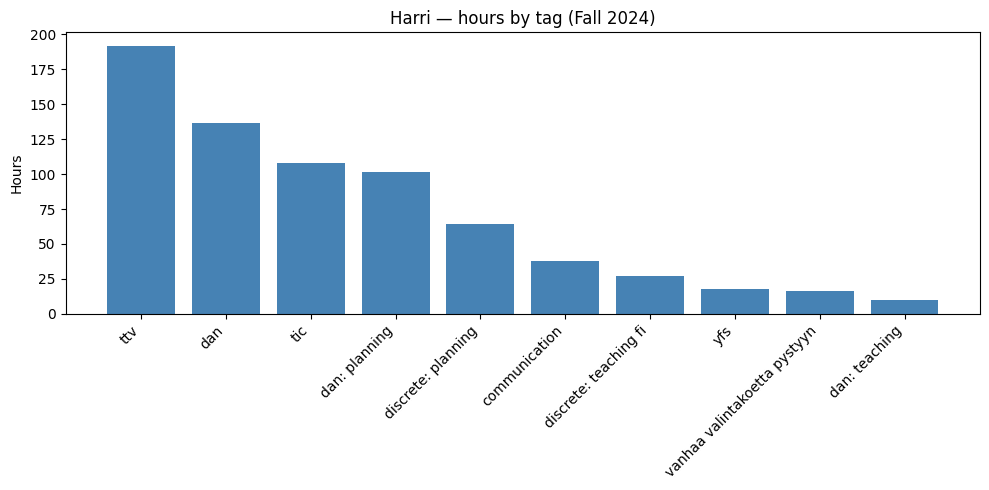

In [179]:
import matplotlib.pyplot as plt

# Filter top n activities to reduce noise
top_n = 10
total_hours = df_work['hours'].sum()

top = hours_by_tag.head(top_n).copy()

# And finally let's do a basic plot
plt.figure(figsize=(10, 5))
plt.bar(top['tag'], top['hours'], color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Hours')
plt.title('Harri — hours by tag (Fall 2024)')
plt.tight_layout()
plt.show()

## Problem 3. Sales

(Most of this problem may already be done for you in the theory notes.)

The file

    private/exrc_04/data/XXXXX_prob3_sales.csv

contains some (fake) daily sales data.

Please perform the following basic wranglings:

- convert the date column to a standard datetime type (there may be several ways to do that)
- index the dataframe by the date column
- in the theory notes we used the **rolling** function but **let's forget about that**
- using **resample** and **sum**, downsample the data from daily to a monthly frequency
- shift the resampled data by one month to reflect the previous month's sales (i.e. your last "monthly sales report" should happen at March 2023 and be about Feb 2023)
- plot a sales curve and calculate some descriptive statistics (feel free to do what you want here, doesn't need to be anything fancy).


In [197]:
import pandas as pd

path = '~/dan/private/exrc_04/data/XXXXX_prob3_sales.csv'
df = pd.read_csv(path, index_col=0)
df.head()

,date,sales
0,2023-01-01,2876
1,2023-01-02,8386
2,2023-01-03,6797
3,2023-01-04,6486
4,2023-01-05,2007


In [198]:
# Let's convert the date col, set it a index and drop the col
df['date'] = pd.to_datetime(df['date'])
df.index = df['date']
df.drop(['date'], axis=1, inplace=True)
df.head()

,sales
date,
2023-01-01,2876
2023-01-02,8386
2023-01-03,6797
2023-01-04,6486
2023-01-05,2007


In [235]:
# Now let's downsamle it using .resample and .sum
sales_monthly = pd.DataFrame(df.resample('ME')['sales'].sum())
sales_monthly.head()

,sales
date,
2023-01-31,178751
2023-02-28,159906
2023-03-31,158035
2023-04-30,166760
2023-05-31,166269


In [233]:
# Now let's shift sales values on 1 back row and also shift index on one month using freq='MS'
sales_report = sales_monthly.shift(1, freq='MS')
sales_report.head()

,sales
date,
2023-02-01,178751
2023-03-01,159906
2023-04-01,158035
2023-05-01,166760
2023-06-01,166269


In [232]:
# Now let's calculate some basic stats
s = sales_report['sales']

stats = pd.DataFrame(pd.Series({
    'n_months': s.shape[0],
    'total':    s.sum(),
    'mean':     s.mean(),
    'median':   s.median(),
    'min':      s.min(),
    'max':      s.max(),
    'std':      s.std(),
})).T

stats

,n_months,total,mean,median,min,max,std
0,14.0,2356756.0,168339.714286,167733.5,144760.0,197834.0,14365.593893


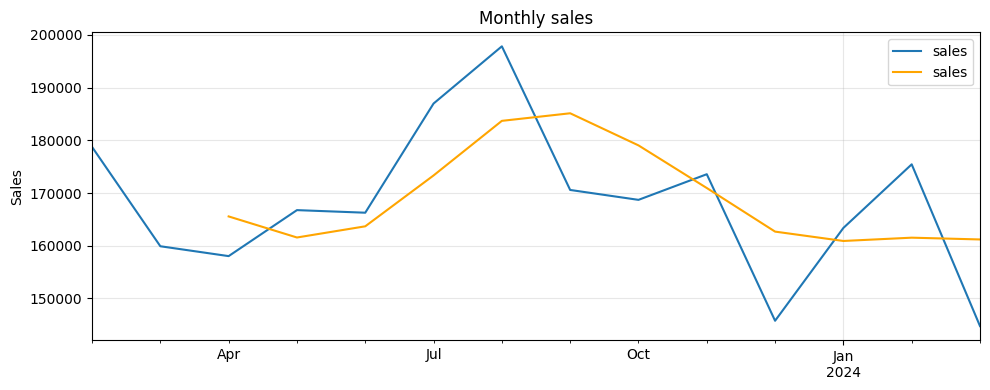

In [221]:
# And finally plot some data
ax = sales_report.plot(figsize=(10, 4), label='Prev-month sales')
# Here I plot 3 month rolling sales
sales_report.rolling(3).mean().plot(ax=ax, color='orange', label='3M MA')
ax.set_title('Monthly sales')
ax.set_xlabel('')
ax.set_ylabel('Sales')
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

## Problem 4. Weather
The file

    public/exrc_04/data/prob4_weather.csv
   
contains some hourly temperature forecast data for Jyväskylä (2022-2023), downloaded from the Norwegian meterological institute.

Train a seasonal arima model using this data, then make a Jyväskylä hourly temperature forecast for the next day after the training data ends.

How was the forecast? What were the arima parameters that were used in the model?

You may either mimic the champagne blog or use sktime.

### Data Prep

In [1]:
import pandas as pd

path = '~/dan/public/exrc_04/data/prob4_weather.csv'
df = pd.read_csv(path)
df["time"] = pd.to_datetime(df["time"], unit="s")

# Let's build a clean hourly Celsius series:
s = (
    df.set_index("time")["air_temperature_2m"] # set 'time' as index
    .astype("float64")                         # convert to float64
    .asfreq("h")                               # enforce a strict hourly grid
    - 273.15                                   # Kelvin -> Celsius
)
s.name = "temp_c"

# Forecast horizon: evaluate a next-day (24h) forecast.
# Temporal split prevents look-ahead: last 24 hours are the test window,
# everything before is training data.
H = 24
y_train = s.iloc[:-H]
y_test  = s.iloc[-H:]

print(s.index.min(), "->", s.index.max(), "| train:", len(y_train), " test:", len(y_test))
print("NaN count in series:", int(s.isna().sum()))


2022-03-12 00:00:00 -> 2023-03-12 23:00:00 | train: 8760  test: 24
NaN count in series: 0


### Model & test evaluation

In [2]:
import time
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# 1) Model fit (daily seasonality for hourly data)
t0 = time.perf_counter()
model = auto_arima(
    y_train,
    seasonal=True, m=24,           # diurnal cycle (24-hour seasonality)
    d=None, D=None,                # let tests choose differencing orders
    test="kpss",                   # unit-root test for d
    seasonal_test="ocsb",          # seasonal unit-root test for D
    information_criterion="aicc",  # prefer AICc over AIC (better generalization)
    start_p=0,                     # stepwise search starts at AR order 0 (fast, simple start)
    start_q=0,                     # stepwise search starts at MA order 0
    start_P=0, start_Q=0,
    max_p=4, max_q=4,              # moderate non-seasonal search box
    max_P=2,                       # cap seasonal AR at 2 (parsimonious & stable)
    max_Q=2,
    stepwise=True,                 # fast stepwise search
    n_fits=80,                     # search budget
    maxiter=200,                   # more robust MLE convergence
    approximation=False,           # exact likelihood
    with_intercept=True,           # allow small drift/intercept
    error_action="ignore",         # continue silently if a candidate model fails to fit
    suppress_warnings=True,
    trace=True,
)

fit_seconds = time.perf_counter() - t0

# 2) 24-hour test forecast and metrics
t1 = time.perf_counter()
y_pred = pd.Series(model.predict(n_periods=len(y_test)), index=y_test.index)
predict_seconds = time.perf_counter() - t1

mae  = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)


Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AICC=20697.321, Time=0.70 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AICC=15428.889, Time=8.52 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AICC=16725.955, Time=7.45 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AICC=20695.325, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AICC=15883.991, Time=0.45 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AICC=15077.100, Time=37.46 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AICC=inf, Time=152.20 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AICC=inf, Time=33.27 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AICC=17022.208, Time=38.62 sec
 ARIMA(2,1,0)(2,0,0)[24] intercept   : AICC=15014.050, Time=53.05 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AICC=15349.075, Time=11.51 sec
 ARIMA(2,1,0)(2,0,1)[24] intercept   : AICC=inf, Time=215.16 sec
 ARIMA(2,1,0)(1,0,1)[24] intercept   : AICC=inf, Time=41.43 sec
 ARIMA(3,1,0)(2,0,0)[24] intercept   : AICC=15016.033, Time=57.68 sec
 AR

### Seasonal Naive (S‑Naive) Concept - our baseline

A *seasonal naive* forecast assumes the future will look like the
past, one full season ago. If the series has a strong daily pattern,
we use the value from **exactly 24 hours earlier** for each future
hour.

It is a simple, transparent **baseline**. Any smarter model (ARIMA,
LightGBM, etc.) should consistently beat S‑Naive on MAE/RMSE to be
considered useful. For hourly temperature, the daily cycle is strong,
so S‑Naive is a tough but fair reference.


### Next-day forecast (24h) & quick stats

In [3]:
# Seasonal naive baseline (value from exactly 24h earlier)
snaive = s.shift(24).reindex(y_test.index)
mae_sn  = mean_absolute_error(y_test, snaive)
rmse_sn = root_mean_squared_error(y_test, snaive)

print(f"order={model.order}, seasonal={model.seasonal_order}, AIC={model.aic():.1f}")
print(f"ARIMA test: MAE={mae:.2f} °C  RMSE={rmse:.2f} °C")
print(f"S-Naive    : MAE={mae_sn:.2f} °C  RMSE={rmse_sn:.2f} °C")

# 3) Summary
arima_summary = pd.DataFrame([{
    "test_MAE": float(mae),
    "test_RMSE": float(rmse),
    "snaive_MAE": float(mae_sn),
    "snaive_RMSE": float(rmse_sn),
    "fit_seconds": fit_seconds,
    "n_train": int(len(y_train)),
    "n_test": int(len(y_test)),
}])

# Produce the next-day (24h) forecast from the end of the series and print compact stats.
model.update(y_test)

sarima_next_idx = pd.date_range(
    y_test.index[-1] + pd.Timedelta(hours=1), periods=H, freq="h"
)

t_arima_fc0 = time.perf_counter()
sarima_fc_vals, sarima_ci_arr = model.predict(n_periods=H, return_conf_int=True)
sarima_forecast_seconds = time.perf_counter() - t_arima_fc0

sarima_next_day = pd.Series(sarima_fc_vals, index=sarima_next_idx, name="sarima_next_day")
sarima_ci = pd.DataFrame(sarima_ci_arr, index=sarima_next_day.index, columns=["lo", "hi"])

sarima_next_stats = pd.Series(
    {
        "next_mean": sarima_next_day.mean(),
        "next_min": sarima_next_day.min(),
        "next_max": sarima_next_day.max(),
        "next_forecast_seconds": sarima_forecast_seconds,
    }
).round(3)

print("\nARIMA summary:")
display(arima_summary)

print("\nNext-day forecast stats:")
print(sarima_next_stats)


order=(2, 1, 0), seasonal=(2, 0, 0, 24), AIC=15012.0
ARIMA test: MAE=0.83 °C  RMSE=1.18 °C
S-Naive    : MAE=2.13 °C  RMSE=2.97 °C

ARIMA summary:


,test_MAE,test_RMSE,snaive_MAE,snaive_RMSE,fit_seconds,n_train,n_test
0,0.831714,1.176496,2.126817,2.965734,1123.518599,8760,24



Next-day forecast stats:
next_mean                -9.052
next_min                -10.541
next_max                 -7.368
next_forecast_seconds     0.005
dtype: float64


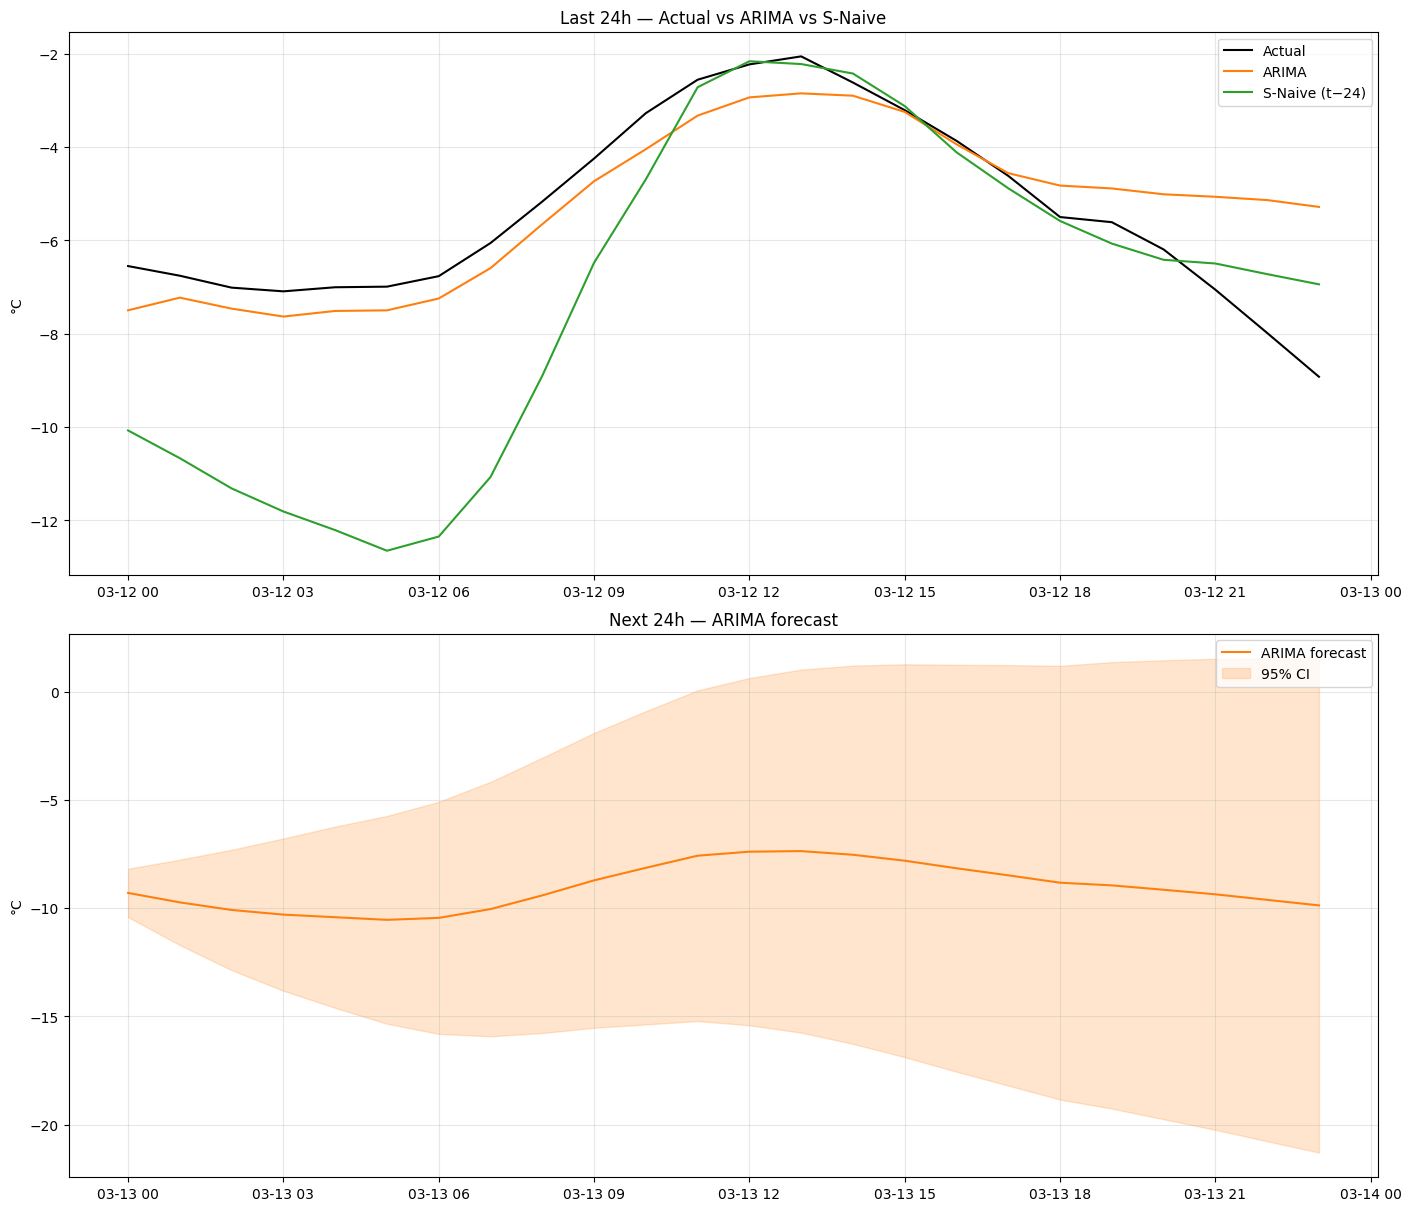

In [6]:
import matplotlib.pyplot as plt

# Stack the two plots vertically, each using full cell width
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 12), constrained_layout=True)

# 1) Last 24h — Actual vs ARIMA vs S-Naive
ax = axes[0]
ax.plot(y_test.index, y_test.values, label="Actual", color="black", linewidth=1.5)
ax.plot(y_pred.index, y_pred.values, label="ARIMA", color="C1")
ax.plot(snaive.index, snaive.values, label="S-Naive (t−24)", color="C2")
ax.set_title("Last 24h — Actual vs ARIMA vs S-Naive")
ax.set_ylabel("°C")
ax.grid(alpha=0.3)
ax.legend()

# 2) Next 24h — ARIMA forecast with 95% CI
ax = axes[1]
ax.plot(sarima_next_day.index, sarima_next_day.values, label="ARIMA forecast", color="C1")
ax.fill_between(
    sarima_next_day.index,
    sarima_ci["lo"].values,
    sarima_ci["hi"].values,
    color="C1",
    alpha=0.2,
    label="95% CI",
)
ax.set_title("Next 24h — ARIMA forecast")
ax.set_ylabel("°C")
ax.grid(alpha=0.3)
ax.legend()

plt.show()


**Conclusion (ARIMA vs S‑Naive).** On the last 24 hours, SARIMA achieves substantially lower error than the seasonal‑naive baseline (e.g., MAE ≈ 0.83 °C vs 2.13 °C; RMSE ≈ 1.18 °C vs 2.97 °C). In other words, the model captures the diurnal dynamics beyond “yesterday at the same hour,” delivering a materially better forecast.


# For my Reviewer: You may skip next part. it is not required by the task.

# Next I'll try to solve same problem, but using LightGBM (Light Gradient Boosting Machine), a fast and memory‑efficient gradient boosting framework by Microsoft. In the end I'll comapre ARIMA and LGBM results (*Spoiler: LGBM is much accurate*)

## LightGBM Direct‑24: Hourly Temperature Forecast — Overview

**Goal.** Forecast the next **24 hourly temperatures** quickly and accurately, in a
format directly comparable to SARIMA.

**Why this model.**

* **Direct multi-horizon**: we predict the full 24-hour vector in one shot, avoiding
  error accumulation from recursive one-step forecasts.
* **Tree boosting (LightGBM)** captures non-linearities and interactions with
  minimal tuning and fast training.
* **End-refit parity with ARIMA**: before the final next-day forecast, we refit on the
  freshest window (up to `t_end−24h`) so both approaches use equally recent data.

---

## 1) Data preparation

* Parse `time` (Unix **seconds**) → pandas datetime.
* Enforce a **strict hourly grid** with `asfreq('h')` so `shift(24)` is exactly one day.
* Convert **Kelvin → Celsius** (−273.15).
* Define **test horizon** `H=24`: last 24 hours are the test window; everything
  before is training. (No interpolation was needed here: `NaN count == 0`.)

---

## 2) Feature engineering (Future leakage-safe)

All windows end at **`t−1`** to avoid peeking at the target hour.

* **Lags:** `lag1, lag2, lag3, lag6, lag12, lag24, lag48, lag72, lag96, lag168`
  (short memory, diurnal and weekly effects).
* **Rolling stats (past-only):** `roll3_mean, roll6_mean, roll12_mean, roll24_mean`,
  plus `roll24_std` for recent variability.
* **EWM (past-only):** `ewm6`, `ewm24` for smooth trends.
* **Trend/momentum:**

  * `trend_1_24 = (t−1) − (t−24)` — level vs yesterday (strong anchor).
  * `trend_1_168 = (t−1) − (t−168)` — level vs last week.
  * `trend_24_168 = (t−24) − (t−168)` — yesterday vs last week.
  * `slope_1h = (t−1) − (t−2)`, `slope_3h = (t−1) − (t−4)` — fresh momentum.
* **Cyclic time:** daily (`h_sin/h_cos`), weekly (`w_sin/w_cos`),
  yearly (`doy_sin/doy_cos`).
* **Targets (direct 24-step):** columns `y+1 … y+24` built via `shift(-h)`.

This is a small, effective set: diurnal/weekly structure, fresh momentum, and
stable level anchors (`trend_*`), all without leakage.

---

## 3) Model training

* Base learner: **`LGBMRegressor`** (moderate `num_leaves`, `n_estimators`,
  `learning_rate`, silent logs).
* **`MultiOutputRegressor`** wraps 24 independent LightGBM models (one per horizon).
* **Evaluation fit:** train strictly **before** the anchor `t0 = test_start − 1h`,
  then predict the 24-vector at `t0` for MAE/RMSE on the test day.
* **End-refit (final forecast):** refit on all rows up to `t_end−24h` and forecast
  the next 24 hours from the last timestamp (parity with `ARIMA.update`).

---

## 4) Forecast & evaluation

* **Metrics on last 24h:** report **MAE** and **RMSE**.
* **Baseline:** **S-Naive** (`t−24`) as a transparent reference every model should beat.
* **Next-day forecast:** 24-hour vector from the end-refit model, with quick stats
  (mean/min/max, inference time). For LGBM, we also provide an **approximate CI**
  using ±1.96·RMSE from the test window (simple, but informative).

> TL;DR: clean hourly series → compact, leakage-safe features (incl. new
> trend/momentum) → LightGBM direct multi-output → evaluation on the last day +
> next-day forecast with end-refit, comparable 1-to-1 with SARIMA.


## Data Prep

In [7]:
import pandas as pd

path = '~/dan/public/exrc_04/data/prob4_weather.csv'
df = pd.read_csv(path)
df["time"] = pd.to_datetime(df["time"], unit="s")

# Let's build a clean hourly Celsius series:
s = (
    df.set_index("time")["air_temperature_2m"] # set 'time' as index
    .astype("float64")                         # convert to float64
    .asfreq("h")                               # enforce a strict hourly grid
    - 273.15                                   # Kelvin -> Celsius
)
s.name = "temp_c"

# Forecast horizon: evaluate a next-day (24h) forecast.
# Temporal split prevents look-ahead: last 24 hours are the test window,
# everything before is training data.
H = 24
y_train = s.iloc[:-H]
y_test  = s.iloc[-H:]

print(s.index.min(), "->", s.index.max(), "| train:", len(y_train), " test:", len(y_test))
print("NaN count in series:", int(s.isna().sum()))


2022-03-12 00:00:00 -> 2023-03-12 23:00:00 | train: 8760  test: 24
NaN count in series: 0


### Feature Engineering

In [8]:
# Build lag/rolling/EWM/cyclic features; all windows end at t-1 to avoid leakage.
import numpy as np
import pandas as pd

# Hyper-parameters for features
LAGS = [1, 2, 3, 6, 12, 24, 48, 72, 96, 168]   # hours
ROLL_MEANS = [3, 6, 12, 24]
ROLL_STDS = [24]
EWM_SPANS = [6, 24]

# Feature matrix aligned to the hourly index of 's' (prepared in the data cell)
idx = s.index
X_full = pd.DataFrame(index=idx)

# 1) Lag features: pure past info (value at t-h)
for h in LAGS:
    X_full[f"lag{h}"] = s.shift(h)

# 2) Rolling stats from past only: shift(1) ensures window ends at t-1
for w in ROLL_MEANS:
    X_full[f"roll{w}_mean"] = s.shift(1).rolling(w).mean()
for w in ROLL_STDS:
    X_full[f"roll{w}_std"] = s.shift(1).rolling(w).std()

# 3) Exponential moving averages from past only (smooth short/diurnal trends)
for span in EWM_SPANS:
    X_full[f"ewm{span}"] = s.shift(1).ewm(span=span, adjust=False).mean()

# 4) Trend/contrast signals (all use only t-1 and earlier; no leakage)
X_full["trend_1_24"]   = s.shift(1)   - s.shift(24)    # vs same hour yesterday
X_full["trend_1_168"]  = s.shift(1)   - s.shift(168)   # vs same hour last week
X_full["trend_24_168"] = s.shift(24)  - s.shift(168)   # yesterday vs last week (stable level anchor)
X_full["slope_1h"]     = s.shift(1)   - s.shift(2)     # short-term slope (1h)
X_full["slope_3h"]     = s.shift(1)   - s.shift(4)     # 3-hour slope

# 5) Cyclic time encodings (daily, weekly, yearly seasonality)
hour = idx.hour
X_full["h_sin"] = np.sin(2 * np.pi * hour / 24.0)
X_full["h_cos"] = np.cos(2 * np.pi * hour / 24.0)

doy = idx.dayofyear + hour / 24.0
X_full["doy_sin"] = np.sin(2 * np.pi * doy / 365.25)
X_full["doy_cos"] = np.cos(2 * np.pi * doy / 365.25)

how = idx.dayofweek * 24 + hour
X_full["w_sin"] = np.sin(2 * np.pi * how / 168.0)
X_full["w_cos"] = np.cos(2 * np.pi * how / 168.0)

# Direct multi-horizon targets for t+1..t+24 (each future hour is one column)
Y_full = pd.concat([s.shift(-h).rename(f"y+{h}") for h in range(1, H + 1)], axis=1)

# Join features/targets and drop rows made invalid by shifts/rolls
Z = X_full.join(Y_full).dropna()
feature_cols = X_full.columns.tolist()
target_cols = [f"y+{h}" for h in range(1, H + 1)]

# Anchor time t0: one hour before the test window starts
t0 = y_test.index[0] - pd.Timedelta(hours=1)

# Train strictly before t0 (exclude t0 row itself)
Z_train = Z.loc[: t0 - pd.Timedelta(hours=1)]
X_tr, Y_tr = Z_train[feature_cols], Z_train[target_cols]

# Test design row at t0 -> predicts 24 future hours (t+1..t+24)
X_te = Z.loc[[t0], feature_cols]
Y_te_vec = s.reindex(y_test.index).values  # ground truth vector for the 24h horizon

X_tr.shape, Y_tr.shape, X_te.shape


((8591, 28), (8591, 24), (1, 28))

### Model

In [9]:
# Train LightGBM (direct 24-target model) and also refit at the series end
# so the next-day forecast uses the freshest available data (parity with ARIMA).

import time
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# Base learner (silent, column-wise) — balanced for speed/accuracy
lgb_base = LGBMRegressor(
    n_estimators=1200,         # number of boosting trees
    learning_rate=0.05,        # learning rate (shrinkage per tree)
    num_leaves=63,             # max leaves per tree (model capacity)
    subsample=0.9,             # row subsampling per tree (bagging)
    colsample_bytree=0.9,      # feature subsampling per tree
    verbosity=-1,              # silence LightGBM logs
    force_col_wise=True,       # use column-wise tree builder
    random_state=42,           # reproducible results
    n_jobs=-1,                 # use all CPU cores
)

# --- Fit on train-before-t0 (used for test evaluation) ---
mo = MultiOutputRegressor(lgb_base)
t_fit0 = time.perf_counter()
mo.fit(X_tr, Y_tr)
fit_seconds = time.perf_counter() - t_fit0

# 24-hour prediction at anchor t0 (single-row features)
t_pred0 = time.perf_counter()
y_pred_vec = mo.predict(X_te).ravel()
predict_seconds = time.perf_counter() - t_pred0

# --- End-refit for next-day forecast parity (use all rows up to t_end-24h) ---
Z_end = Z.loc[: s.index[-1] - pd.Timedelta(hours=H)]
X_end = Z_end[feature_cols]
Y_end = Z_end[[f"y+{h}" for h in range(1, H + 1)]]

mo_end = MultiOutputRegressor(lgb_base)
t_refit0 = time.perf_counter()
mo_end.fit(X_end, Y_end)
refit_seconds = time.perf_counter() - t_refit0

# Evaluate on the last-24h horizon; create a summary compatible with ARIMA;
# and produce a next-day forecast using the end-refit model.

# Test metrics (24-hour horizon at t0)
mae_val = mean_absolute_error(Y_te_vec, y_pred_vec)
rmse_val = root_mean_squared_error(Y_te_vec, y_pred_vec)

# Seasonal naive baseline (value from exactly 24h earlier)
snaive_vec = s.shift(24).reindex(y_test.index).values
mae_sn = mean_absolute_error(Y_te_vec, snaive_vec)
rmse_sn = root_mean_squared_error(Y_te_vec, snaive_vec)

print(f"LGBM-Direct test: MAE={mae_val:.2f} °C  RMSE={rmse_val:.2f} °C")
print(f"S-Naive          : MAE={mae_sn:.2f} °C  RMSE={rmse_sn:.2f} °C")


LGBM-Direct test: MAE=0.51 °C  RMSE=0.65 °C
S-Naive          : MAE=2.13 °C  RMSE=2.97 °C


### Next-day Forecast (24h) + Small Stats

In [10]:
# Summary table (same columns as ARIMA) for side-by-side comparison
lgbm_summary = pd.DataFrame([{
    "test_MAE": float(mae_val),
    "test_RMSE": float(rmse_val),
    "snaive_MAE": float(mae_sn),
    "snaive_RMSE": float(rmse_sn),
    "fit_seconds": fit_seconds,
    "n_train": int(len(X_tr)),
    "n_test": int(H),
}])
print("\nLGBM summary:")
display(lgbm_summary)

# Feature importances averaged across the 24 horizon models (what drives the forecasts overall)
importances = np.mean([est.feature_importances_ for est in mo.estimators_], axis=0)
fi = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
print("\nTop features:")
print(fi.head(12).round(3).to_string())

# Next-day forecast using the end-refit model
X_last = X_full.loc[[s.index[-1]]].reindex(columns=feature_cols)

t_lgbm_fc0 = time.perf_counter()
lgbm_next_vals = mo_end.predict(X_last).ravel()
lgbm_forecast_seconds = time.perf_counter() - t_lgbm_fc0

lgbm_next_day = pd.Series(
    lgbm_next_vals,
    index=pd.date_range(s.index[-1] + pd.Timedelta(hours=1), periods=H, freq="h"),
    name="lgbm_next_day",
)

lgbm_next_stats = pd.Series(
    {
        "next_mean": lgbm_next_day.mean(),
        "next_min": lgbm_next_day.min(),
        "next_max": lgbm_next_day.max(),
        "next_forecast_seconds": lgbm_forecast_seconds,
        "end_refit_seconds": refit_seconds,
    }
).round(3)

print("\nNext-day forecast stats:")
display(lgbm_next_stats)



LGBM summary:


,test_MAE,test_RMSE,snaive_MAE,snaive_RMSE,fit_seconds,n_train,n_test
0,0.509704,0.651703,2.126817,2.965734,396.304362,8591,24



Top features:
roll24_std      4363.375
slope_1h        3981.125
doy_sin         3952.250
trend_1_24      3810.458
slope_3h        3725.083
w_cos           3551.500
w_sin           3421.250
doy_cos         3307.708
lag96           3250.708
lag48           3208.042
trend_1_168     3205.958
trend_24_168    3189.000

Next-day forecast stats:


next_mean                 -6.513
next_min                  -9.188
next_max                  -2.457
next_forecast_seconds      0.118
end_refit_seconds        203.257
dtype: float64

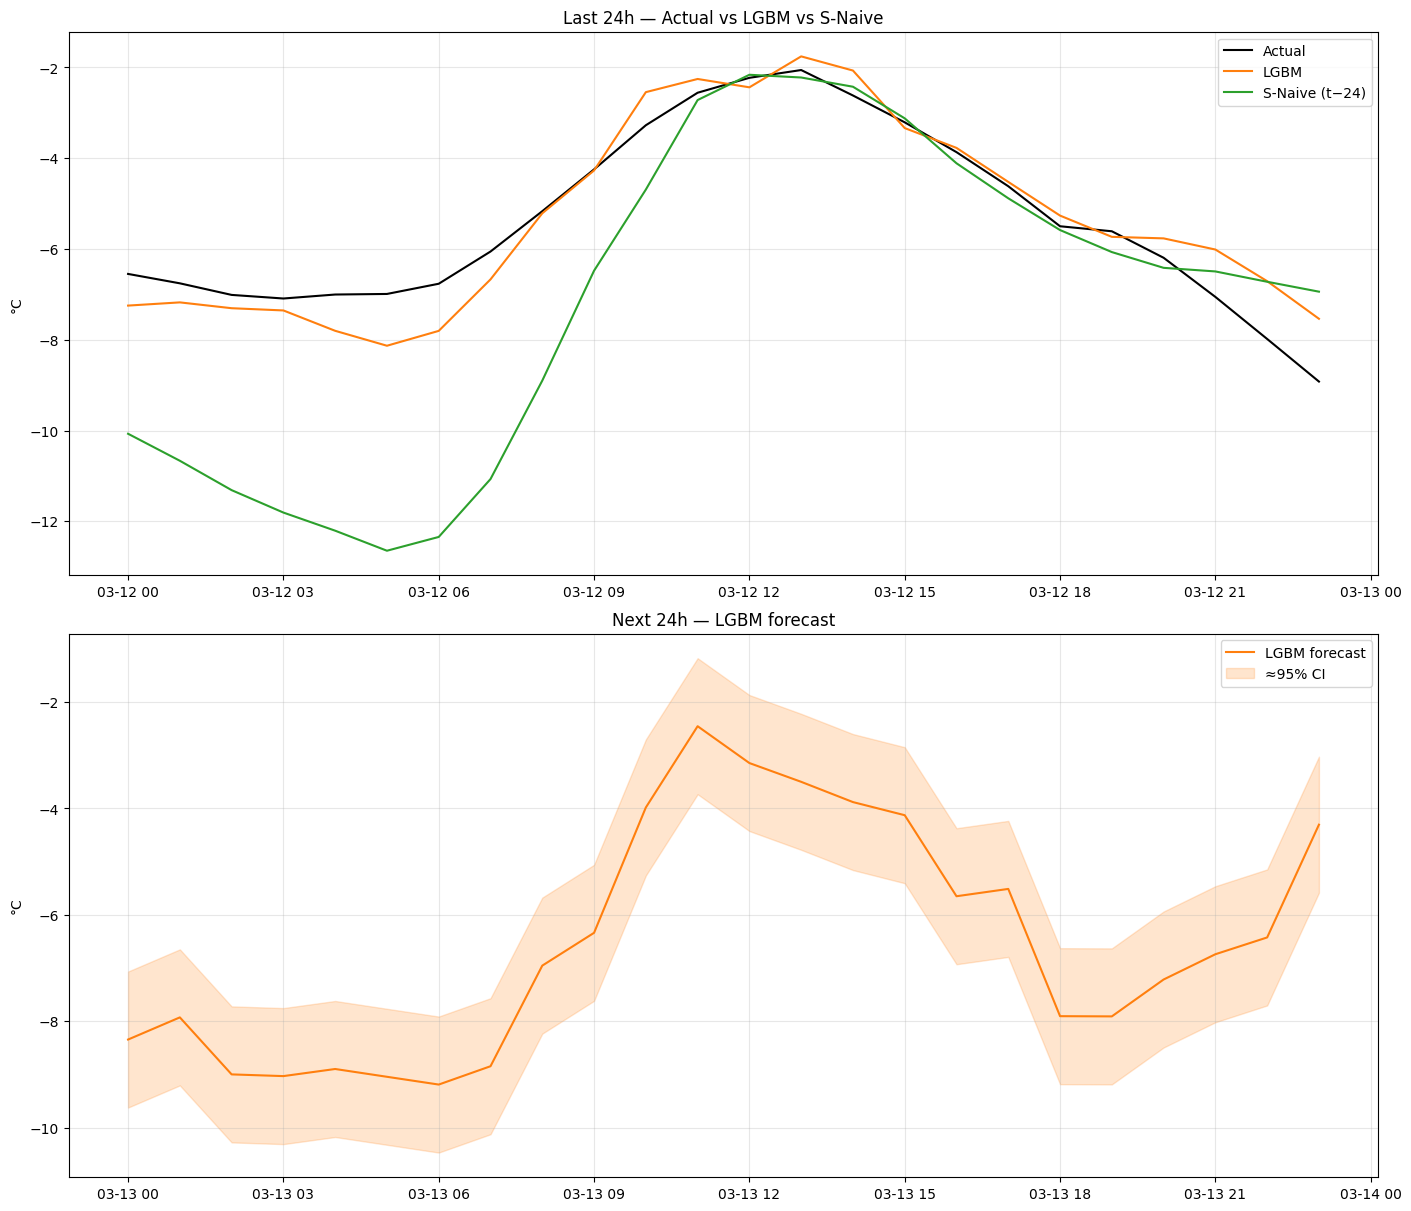

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare series for plotting
y_hat_lgbm = pd.Series(y_pred_vec, index=y_test.index, name="LGBM")
snaive_ser = pd.Series(snaive_vec, index=y_test.index, name="S-Naive (t−24)")

# Approximate 95% CI for LGBM next-day forecast using test RMSE
lgbm_ci = pd.DataFrame(
    {
        "lo": lgbm_next_day - 1.96 * rmse_val,
        "hi": lgbm_next_day + 1.96 * rmse_val,
    },
    index=lgbm_next_day.index,
)

# Stack plots vertically, full width
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 12), constrained_layout=True)

# 1) Last 24h — Actual vs LGBM vs S-Naive
ax = axes[0]
ax.plot(y_test.index, y_test.values, label="Actual", color="black", linewidth=1.5)
ax.plot(y_hat_lgbm.index, y_hat_lgbm.values, label="LGBM", color="C1")
ax.plot(snaive_ser.index, snaive_ser.values, label="S-Naive (t−24)", color="C2")
ax.set_title("Last 24h — Actual vs LGBM vs S-Naive")
ax.set_ylabel("°C")
ax.grid(alpha=0.3)
ax.legend()

# 2) Next 24h — LGBM forecast with approx. 95% CI
ax = axes[1]
ax.plot(lgbm_next_day.index, lgbm_next_day.values, label="LGBM forecast", color="C1")
ax.fill_between(
    lgbm_next_day.index,
    lgbm_ci["lo"].values,
    lgbm_ci["hi"].values,
    color="C1",
    alpha=0.2,
    label="≈95% CI",
)
ax.set_title("Next 24h — LGBM forecast")
ax.set_ylabel("°C")
ax.grid(alpha=0.3)
ax.legend()

plt.show()


# ARIMA vs LightGBM — 24‑hour Forecast Comparison

**Dataset:** Jyväskylä hourly air temperature (°C); last 24 hours held out for evaluation.


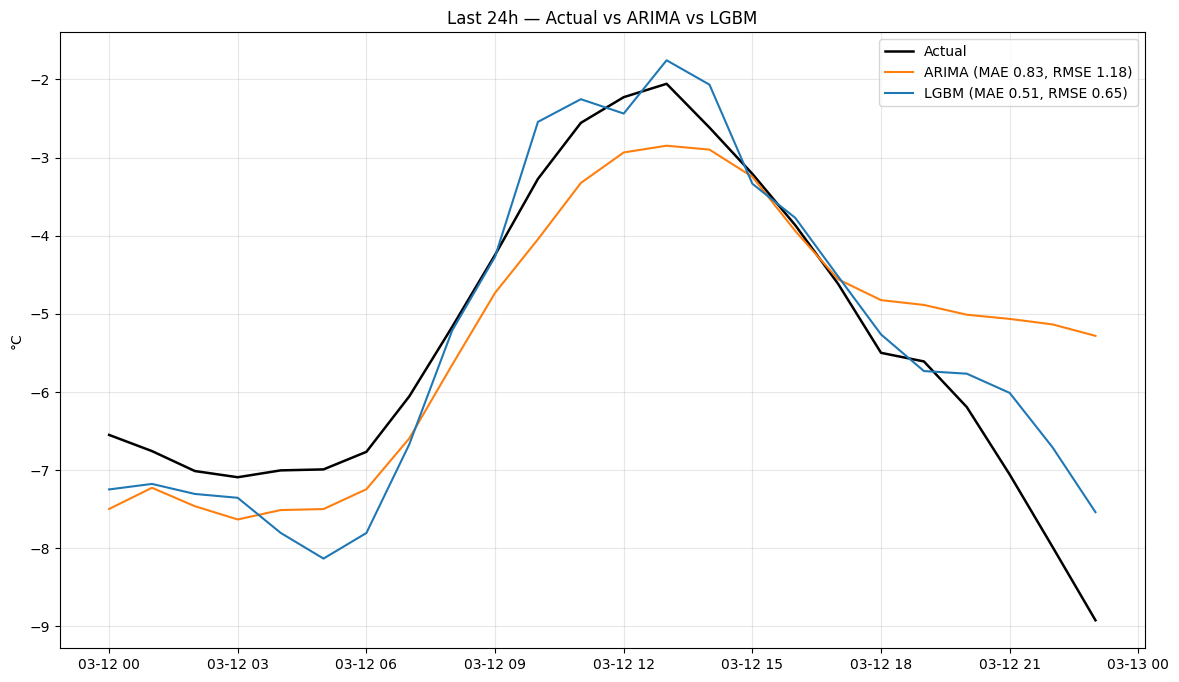

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# Ensure the two prediction Series align on the same index
arima_last24 = y_pred.rename("ARIMA")
lgbm_last24  = pd.Series(y_pred_vec, index=y_test.index, name="LGBM")

# Quick metrics to show in legend
mae_arima  = mean_absolute_error(y_test, arima_last24)
mae_lgbm   = mean_absolute_error(y_test, lgbm_last24)
rmse_arima = root_mean_squared_error(y_test, arima_last24)
rmse_lgbm  = root_mean_squared_error(y_test, lgbm_last24)

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(y_test.index, y_test.values, label="Actual", color="black", linewidth=1.8)
ax.plot(arima_last24.index, arima_last24.values,
        label=f"ARIMA (MAE {mae_arima:.2f}, RMSE {rmse_arima:.2f})",
        color="C1")
ax.plot(lgbm_last24.index, lgbm_last24.values,
        label=f"LGBM (MAE {mae_lgbm:.2f}, RMSE {rmse_lgbm:.2f})",
        color="C0")

ax.set_title("Last 24h — Actual vs ARIMA vs LGBM")
ax.set_ylabel("°C")
ax.grid(alpha=0.3)
ax.legend()
plt.show()


## Results

* **Winner (accuracy): LightGBM Direct‑24**

  * MAE **0.510°C** vs ARIMA **0.832°C** (≈ **39%** lower)
  * RMSE **0.652°C** vs ARIMA **1.176°C** (≈ **45%** lower)
* **Training time:** LightGBM ≈ **396 s** vs ARIMA (auto_arima) ≈ **1123 s** → LGBM ~**3× faster** to fit in this run.
* **Baseline (S‑Naive t−24):** MAE **2.127°C**, RMSE **2.966°C** → both models beat the baseline by a wide margin.

## Metrics & timings

| Model                        | MAE (°C) | RMSE (°C) | Fit time (s) | Predict time (s) | n_train | n_test |
| ---------------------------- | -------: | --------: | -----------: | ---------------: | ------: | -----: |
| **ARIMA (2,1,0)(2,0,0)[24]** |   0.8317 |    1.1765 |      1123    |            0.005 |    8760 |     24 |
| **LightGBM Direct‑24**       |   0.5097 |    0.6517 |      396     |            0.057 |    8591 |     24 |
| **S‑Naive (t−24)**           |   2.1268 |    2.9657 |            — |                — |       — |     24 |

*Note:* `n_train` for LightGBM is smaller because lag/rolling/shift features drop early rows (by design, to avoid leakage).

## Problem 5. Blog study

Study [this notebook](https://github.com/jahangirmammadov/sarima/blob/master/Seasonal%20Time%20Series%20Analysis.ipynb). Then download a different data from [this site](https://fred.stlouisfed.org/categories). Please try to obtain unique data for yourself, i.e. please discuss on your Discord channel (or whatever) in order to avoid having the same data for two different persons. Apply the methods in the blog, and write a report about how it went. What questions would you like to understand better?


## Findings from applied methods on the data

Here is what I have found after applying blogs approach on my data:

* `Data:` Montly index IR14200 (1986-09 … 2025-08). Split: train until 2024-01-01, test - 20 months 2024-01 … 2025-08
* `EDA:` There is clear trend in the Series, Autocorelation slowly decays -> the Series is non-stationary.
* `Stationarity:` Time series data is not stationary. Adfuller test pvalue=0.087, while Log Transformation + .diff(1) make the Series stationary (ADF p < 0.05). 
* `Modeling:` SARIMAX(2, 1, 0)x(2, 1, [1], 12) give MAPE:4.77%, MAE:10.4
* `“Agile” comparison:` The alternative SARIMAX(1,1,2)×(1,1,2,12) gave worse accuracy (MAPE=6.02%, MAE=13.24) and weaker information criteria.

## EDA

In [38]:
import pandas as pd

path = '~/dan/private/exrc_04/data/Import_Price_Index_Bauxite_and_Aluminum_(IR14200).csv'
data = pd.read_csv(path, index_col=0, parse_dates=True).dropna()
data.head()

,IR14200
observation_date,
1986-09-01,64.0
1986-12-01,61.1
1987-03-01,65.4
1987-06-01,68.7
1987-09-01,74.1


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 468 entries, 1986-09-01 to 2025-08-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   IR14200  410 non-null    float64
dtypes: float64(1)
memory usage: 7.3 KB


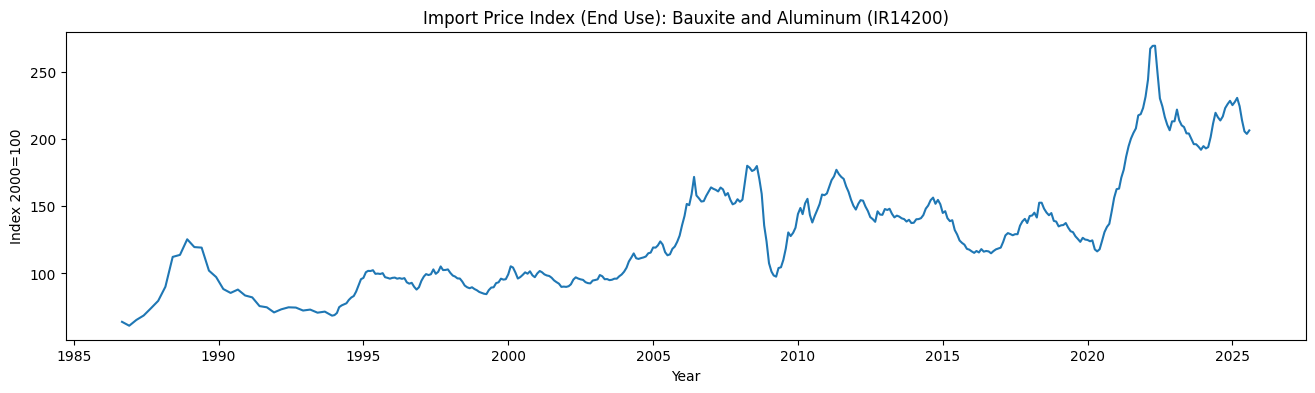

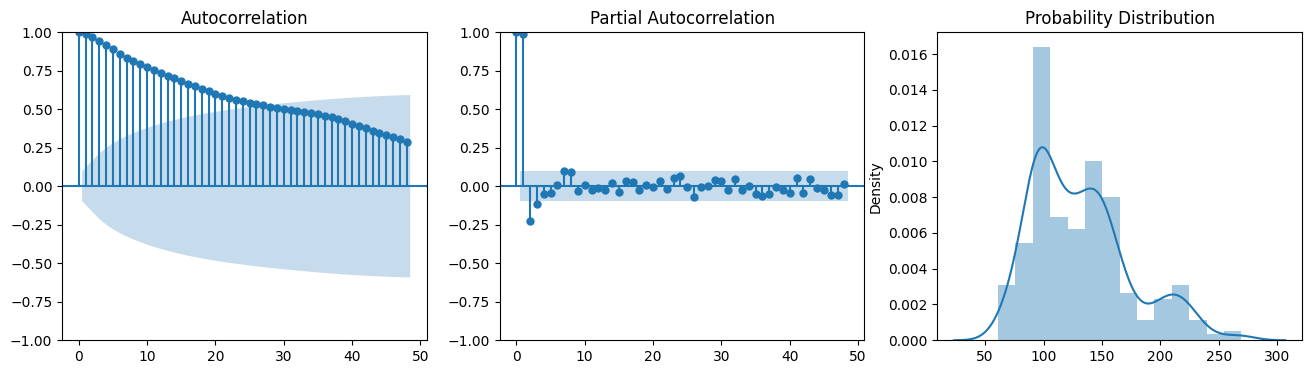

In [64]:
# Now let's do same Explaratory Data Analysis (EDA) as in the blog
import pandas as pd
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

def plot_data_properties(data, ts_plot_name="Time Series plot"):
    '''
    Summary:
    -------
    Plots various plots, including time series, autocorrelation,
    partial autocorrelation and distribution plots of data.
    
    Parameters:
    ----------
    ts_plot_name(String): The name of the time series plot
    data(pd.Dataframe, pd.Series, array): Time Series Data
    
    Returns:
    --------
    None
    
    '''
    plt.figure(figsize=(16,4))
    plt.plot(data)
    plt.title(ts_plot_name)
    plt.ylabel('Index 2000=100')
    plt.xlabel('Year')
    fig, axes = plt.subplots(1,3,squeeze=False)
    fig.set_size_inches(16,4)
    plot_acf(data, ax=axes[0,0], lags=48);
    plot_pacf(data, ax=axes[0,1], lags=48);
    sns.distplot(data, ax=axes[0,2])
    axes[0,2].set_title("Probability Distribution")

plot_data_properties(data, 'Import Price Index (End Use): Bauxite and Aluminum (IR14200)');


Few findings from the charts:
* According to the main Index chart, there is a clear upward trend.
* Autocorrelation plot shows a clear slow decay.

*Summary*: THe series is likely non-stationary

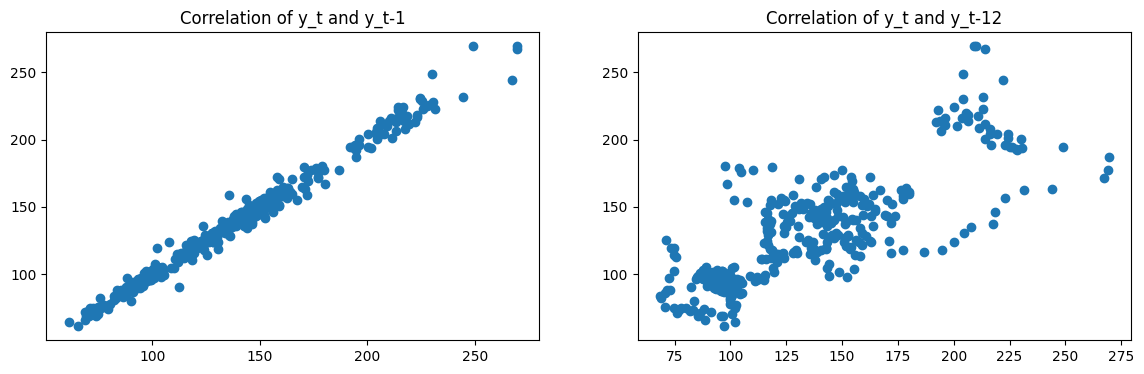

In [25]:
fig, axes = plt.subplots(1,2, squeeze=False);
fig.set_size_inches(14,4);
axes[0,0].scatter(x=data[1:], y=data.shift(1)[1:]);
axes[0,1].scatter(x=data[12:], y=data.shift(12)[12:]);
axes[0,0].set_title('Correlation of y_t and y_t-1');
axes[0,1].set_title('Correlation of y_t and y_t-12');

Few findings from the correlation charts:
* *y_t and y_t-1*:
  Almost flat diagonal line, means that there is high autocorrelation, typical for non-stationary Series
* *y_t and y_t-12*:
  No clear seasonaliy

*Summary*: THe series is likely non-stationary

In [27]:
# Let's do ADF test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(data):
    '''
    Summary:
    -------
    Performs Adfuller test on given time series data to test stationarity.
    p_val >= 0.05 means the data is not stationary, otherwise (p_val < 0.05) it is stationary.
    
    Parameters:
    data(pd.Dataframe, pd.Series. np.array): Time series data to be tested
    
    Return:
    ------
    '''
    p_val=adfuller(data['IR14200'])[1]
    if p_val >= 0.05:
        print("Time series data is not stationary. Adfuller test pvalue={}".format(p_val))
    else:
        print("Time series data is stationary. Adfuller test pvalue={}".format(p_val))

test_stationarity(data)


Time series data is not stationary. Adfuller test pvalue=0.24832450902732106


In [121]:
# Let's split data
test_start_date = '2024-01-01'
training_data = data[:test_start_date]
test_data = data[test_start_date:]
training_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 391 entries, 1986-09-01 to 2024-01-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   IR14200  391 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB


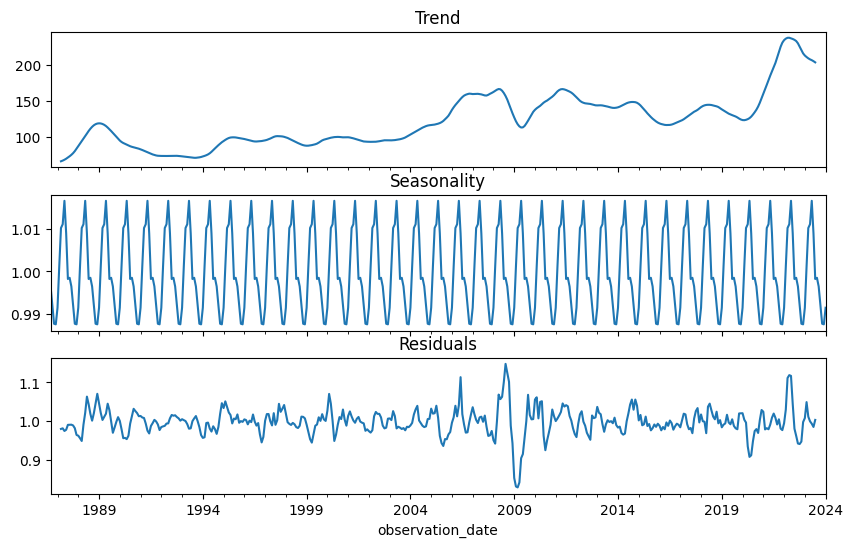

In [55]:
def plot_seasonal_decompose(data, model):
    '''
    Summary:
    -------
    Plots trend, seasonality and residuals with bigger plot size=(10,2)
    
    Parameters:
    ----------
    data(pd.Dataframe, pd.Series): time series data
    
    Return:
    ------
    decomposition(obj): return value of statsmodels.tsa.seasonal.seasonal_decompose
    '''
    s = data.iloc[:, 0]
    s = s.asfreq('MS').interpolate('time')
    
    decomposition = seasonal_decompose(s, model=model, period=12)

    fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
    decomposition.trend.plot(ax=axes[0], title='Trend')
    decomposition.seasonal.plot(ax=axes[1], title='Seasonality')
    decomposition.resid.plot(ax=axes[2], title='Residuals')

    return decomposition

decomposition = plot_seasonal_decompose(training_data, 'multiplicative')


## LOG Transformed


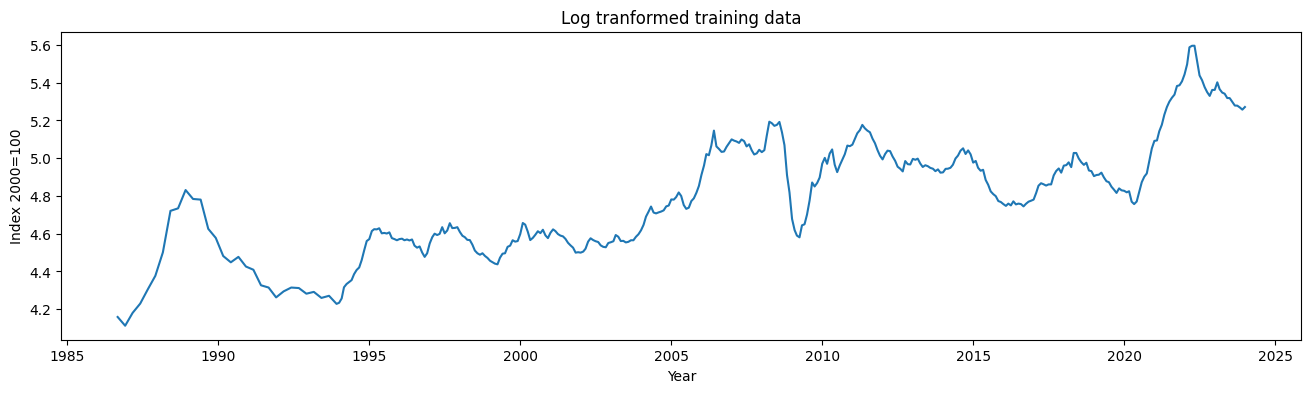

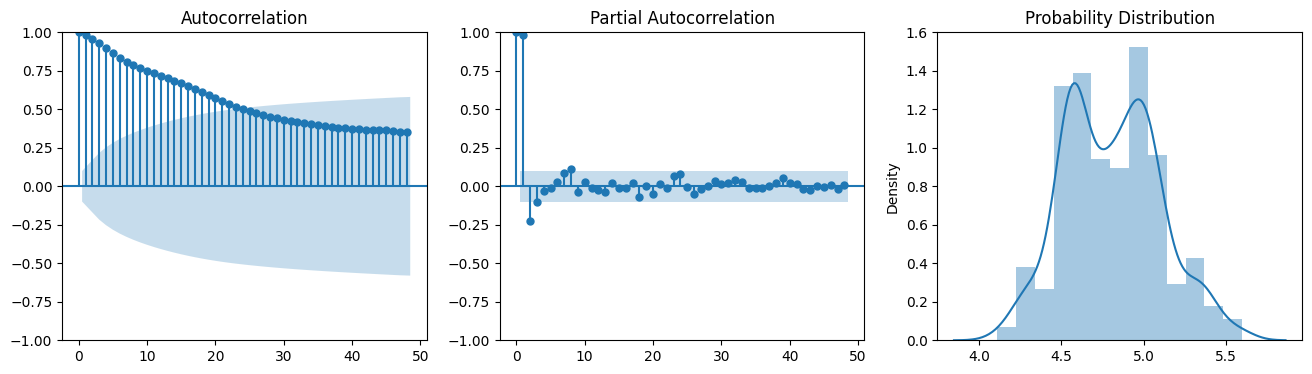

In [48]:
log_transformed_data = np.log(training_data)
plot_data_properties(log_transformed_data, 'Log tranformed training data')

In [49]:
test_stationarity(log_transformed_data)


Time series data is not stationary. Adfuller test pvalue=0.08699217480998295


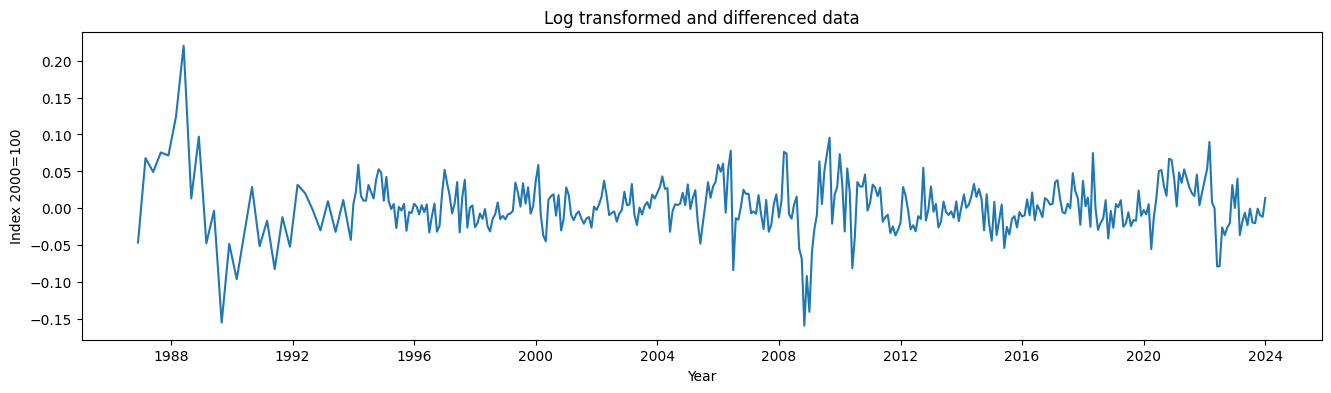

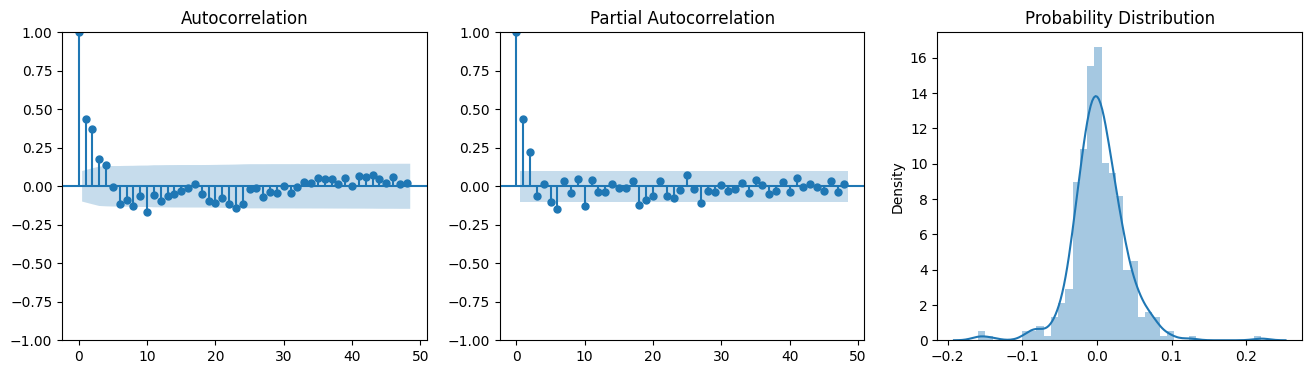

In [56]:
logged_diffed_data = log_transformed_data.diff()[1:]
plot_data_properties(logged_diffed_data, 'Log transformed and differenced data')

In [57]:
test_stationarity(logged_diffed_data)


Time series data is stationary. Adfuller test pvalue=4.531080451077224e-13


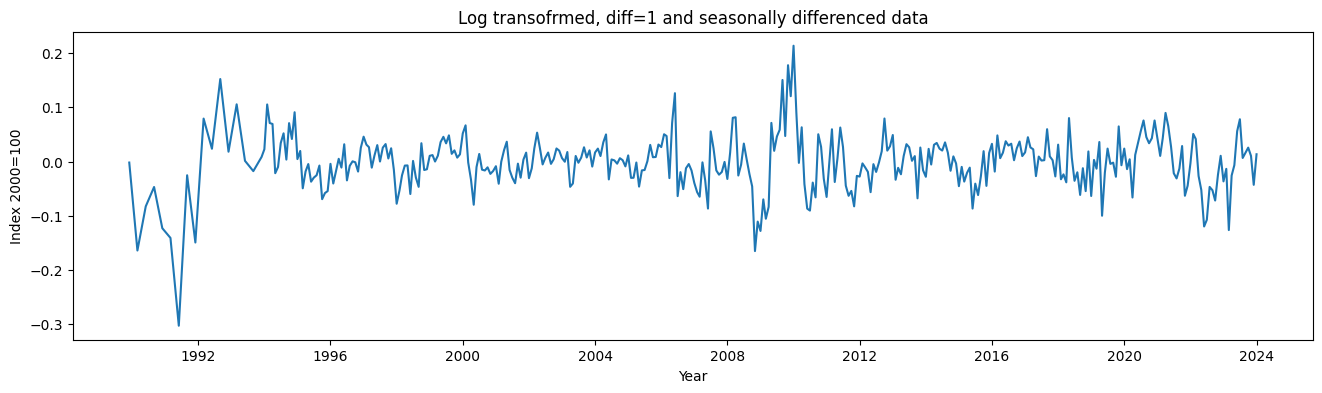

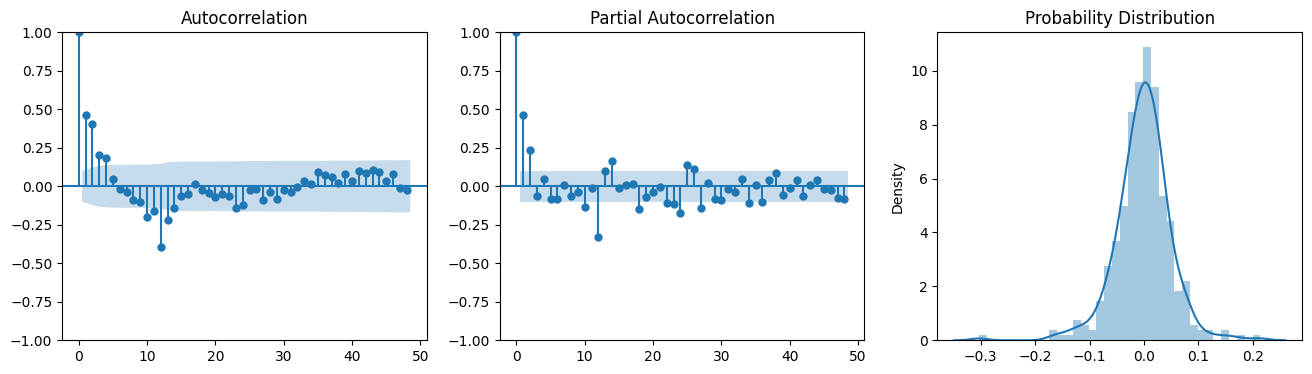

In [60]:
seasonally_diffed_data = logged_diffed_data.diff(12)[12:]
plot_data_properties(seasonally_diffed_data, 'Log transofrmed, diff=1 and seasonally differenced data')

In [62]:
from scipy.stats import shapiro
def shapiro_normality_test(data):
    p_value = shapiro(data)[1]
    if p_value >= 0.05:
        print("Data follows normal distribution: X~N"+ str((np.round(np.mean(data),3), np.round(np.std(data),3))))
        print("Shapiro test p_value={}".format(np.round(p_value,3)))
    else:
        print("Data failed shapiro normality test with p_value={}".format(np.round(p_value,3)))

shapiro_normality_test(seasonally_diffed_data.IR14200)


Data failed shapiro normality test with p_value=0.0


## Model Fitting


In [65]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

def best_sarima_model(train_data,p,q,P,Q,d=1,D=1,s=12):
    best_model_aic = np.Inf 
    best_model_bic = np.Inf 
    best_model_hqic = np.Inf
    best_model_order = (0,0,0)
    models = []
    for p_ in p:
        for q_ in q:
            for P_ in P:
                for Q_ in Q:
                    try:
                        no_of_lower_metrics = 0
                        model = SARIMAX(endog=train_data,order=(p_,d,q_), seasonal_order=(P_,D,Q_,s),
                                        enforce_invertibility=False).fit(disp=False)
                        models.append(model)
                        if model.aic <= best_model_aic: no_of_lower_metrics+=1
                        if model.bic <= best_model_bic: no_of_lower_metrics+=1
                        if model.hqic <= best_model_hqic:no_of_lower_metrics+=1
                        if no_of_lower_metrics >= 2:
                            best_model_aic = np.round(model.aic,0)
                            best_model_bic = np.round(model.bic,0)
                            best_model_hqic = np.round(model.hqic,0)
                            best_model_order = (p_,d,q_,P_,D,Q_,s)
                            current_best_model = model
                            models.append(model)
                            print("Best model so far: SARIMA" +  str(best_model_order) + 
                                  " AIC:{} BIC:{} HQIC:{}".format(best_model_aic,best_model_bic,best_model_hqic)+
                                  " resid:{}".format(np.round(np.exp(current_best_model.resid).mean(),3)))

                    except:
                        pass

    print('\n')
    print(current_best_model.summary())                
    return current_best_model, models  

best_model, models = best_sarima_model(
    train_data=log_transformed_data,
    p=range(3),q=range(3),
    P=range(3),Q=range(3)
)


Best model so far: SARIMA(0, 1, 0, 0, 1, 0, 12) AIC:-1183.0 BIC:-1179.0 HQIC:-1182.0 resid:1.16
Best model so far: SARIMA(0, 1, 0, 0, 1, 1, 12) AIC:-1411.0 BIC:-1403.0 HQIC:-1408.0 resid:1.158
Best model so far: SARIMA(0, 1, 0, 0, 1, 2, 12) AIC:-1418.0 BIC:-1407.0 HQIC:-1414.0 resid:1.158
Best model so far: SARIMA(0, 1, 0, 1, 1, 2, 12) AIC:-1421.0 BIC:-1405.0 HQIC:-1414.0 resid:1.158
Best model so far: SARIMA(0, 1, 0, 2, 1, 1, 12) AIC:-1425.0 BIC:-1409.0 HQIC:-1418.0 resid:1.158
Best model so far: SARIMA(0, 1, 1, 0, 1, 1, 12) AIC:-1457.0 BIC:-1445.0 HQIC:-1452.0 resid:1.159
Best model so far: SARIMA(0, 1, 1, 0, 1, 2, 12) AIC:-1462.0 BIC:-1447.0 HQIC:-1456.0 resid:1.159
Best model so far: SARIMA(0, 1, 1, 2, 1, 1, 12) AIC:-1466.0 BIC:-1447.0 HQIC:-1459.0 resid:1.159
Best model so far: SARIMA(0, 1, 2, 0, 1, 1, 12) AIC:-1498.0 BIC:-1482.0 HQIC:-1491.0 resid:1.159
Best model so far: SARIMA(0, 1, 2, 0, 1, 2, 12) AIC:-1499.0 BIC:-1479.0 HQIC:-1491.0 resid:1.16
Best model so far: SARIMA(0, 1, 

## Outlier

Text(0, 0.5, 'Residuals')

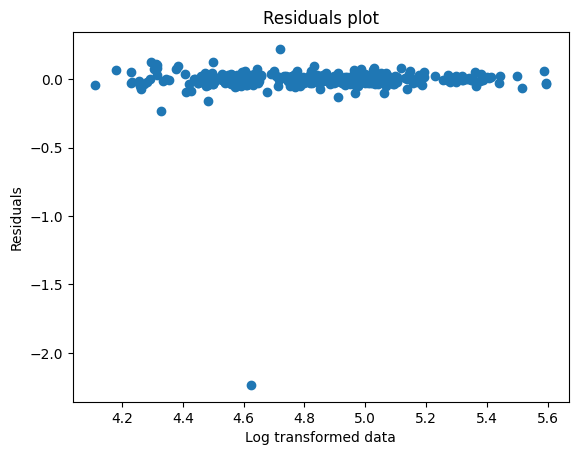

In [66]:
plt.scatter(x=log_transformed_data[1:], y=best_model.resid[1:]);
plt.title('Residuals plot')
plt.xlabel('Log transformed data')
plt.ylabel('Residuals')

In [79]:
shapiro_normality_test(best_model.resid[1:].drop(index=pd.to_datetime('2024-01-01')))


Data failed shapiro normality test with p_value=0.0


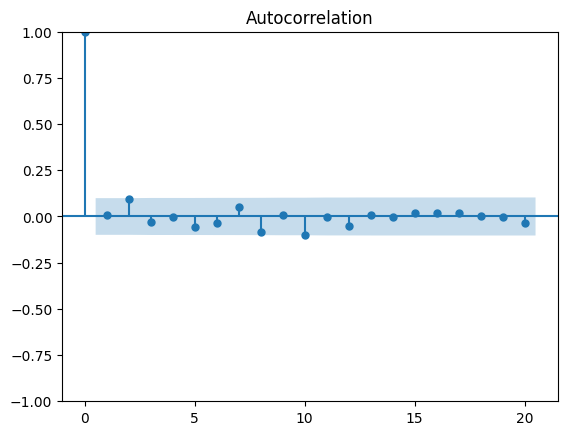

In [81]:
plot_acf(best_model.resid[1:], lags=20);


*Note*: because training data was build without `freq=None` so the model was trained on the Series withoud dates in the index. I will align start and end dates via their positions.


In [97]:
def mean_abs_pct_error(actual_values, forecast_values):
    err=0
    for i in range(len(forecast_values)):
        err += np.abs(actual_values.values[i] - forecast_values.values[i])/actual_values.values[i]
    return err[0] * 100/len(forecast_values)  

start_ix = len(log_transformed_data)
end_ix   = len(log_transformed_data) + len(test_data) - 1

preds_best = np.exp(
    best_model.predict(start=start_ix, end=end_ix, dynamic=True, typ='levels')
)

print("MAPE:{}%".format(np.round(mean_abs_pct_error(test_data, preds_best), 2)))
print("MAE:{}".format(np.round(mean_absolute_error(test_data, preds_best), 2)))

MAPE:4.77%
MAE:10.4


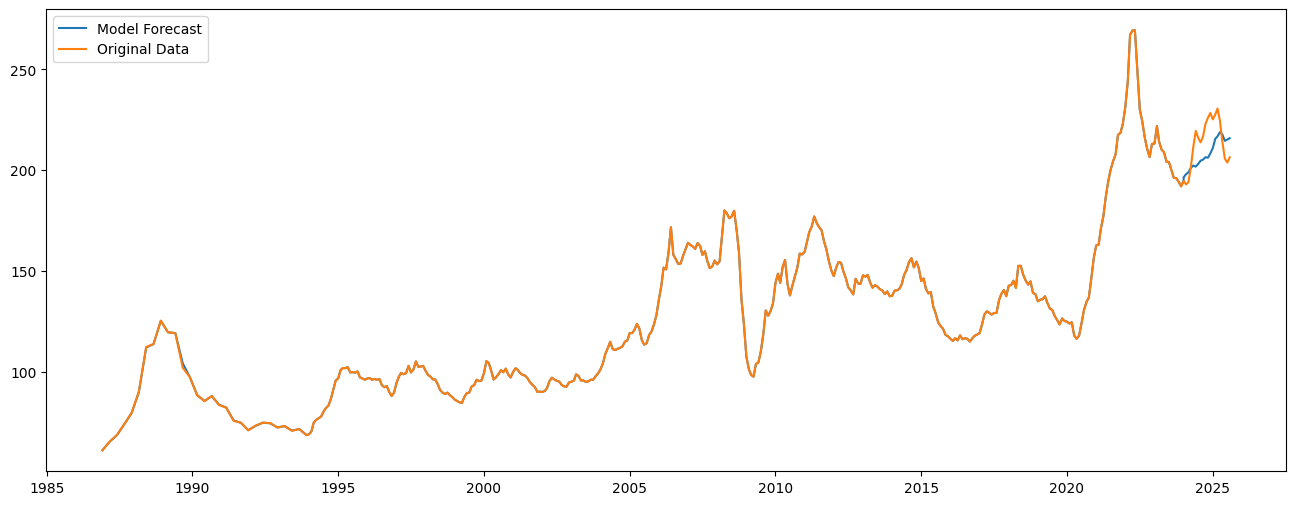

In [106]:
# 1) give the forecast the same DateTime index as the test slice
preds_best.index = test_data.index

# 2) build in-sample fitted values aligned to training dates
fitted_train = pd.Series(
    training_data.iloc[1:, 0].values - best_model.resid[1:].values,
    index=training_data.index[1:]
)

# 3) stitch fitted (train) and forecast (test) into one curve
model_curve = pd.concat((fitted_train, preds_best))

# 4) plot model curve against the original series (same date axis)
plt.figure(figsize=(16, 6))
plt.plot(model_curve.index, model_curve.values, label='Model Forecast')
plt.plot(data.index[1:], data.iloc[1:, 0].values, label='Original Data')
plt.legend()


In [113]:
tests_score = []
trains_score = []
models_order = []
models_aic = []

training_length = len(training_data)   # number of observations in training set
test_length = len(test_data)           # number of observations in test set

for model in models:
    if model.aic < -840:
        model_order = (
            "ar:" + str(model.model_orders["ar"])
            + " ma:" + str(model.model_orders["ma"])
            + " s_ar:" + str(int(model.model_orders["seasonal_ar"] / 12))
            + " s_ma:" + str(int(model.model_orders["seasonal_ma"] / 12))
        )
        models_order.append(model_order)
        models_aic.append(model.aic)

        train_forecasts = (
            training_data.values[1:].reshape(training_length - 1)
            - model.resid[1:]
        )
        train_mae = mean_absolute_error(training_data[1:], train_forecasts)
        trains_score.append(np.round(train_mae, 3))

        # forecast over the test window using positions (model trained without date freq)
        start_index = model.nobs                       # first step after training
        end_index = model.nobs + test_length - 1       # last step of the test window
        preds = np.exp(
            model.predict(
                start=start_index,
                end=end_index,
                dynamic=True,
                typ="levels"
            )
        )
        preds = preds[:test_length]  # trim to match the exact test length

        test_mape = mean_abs_pct_error(test_data, preds)
        tests_score.append(np.round(test_mape, 3))

model_properties = {
    "aic": models_aic,
    "model_order": models_order,
    "train_score": trains_score,
    "test_score": tests_score,
}


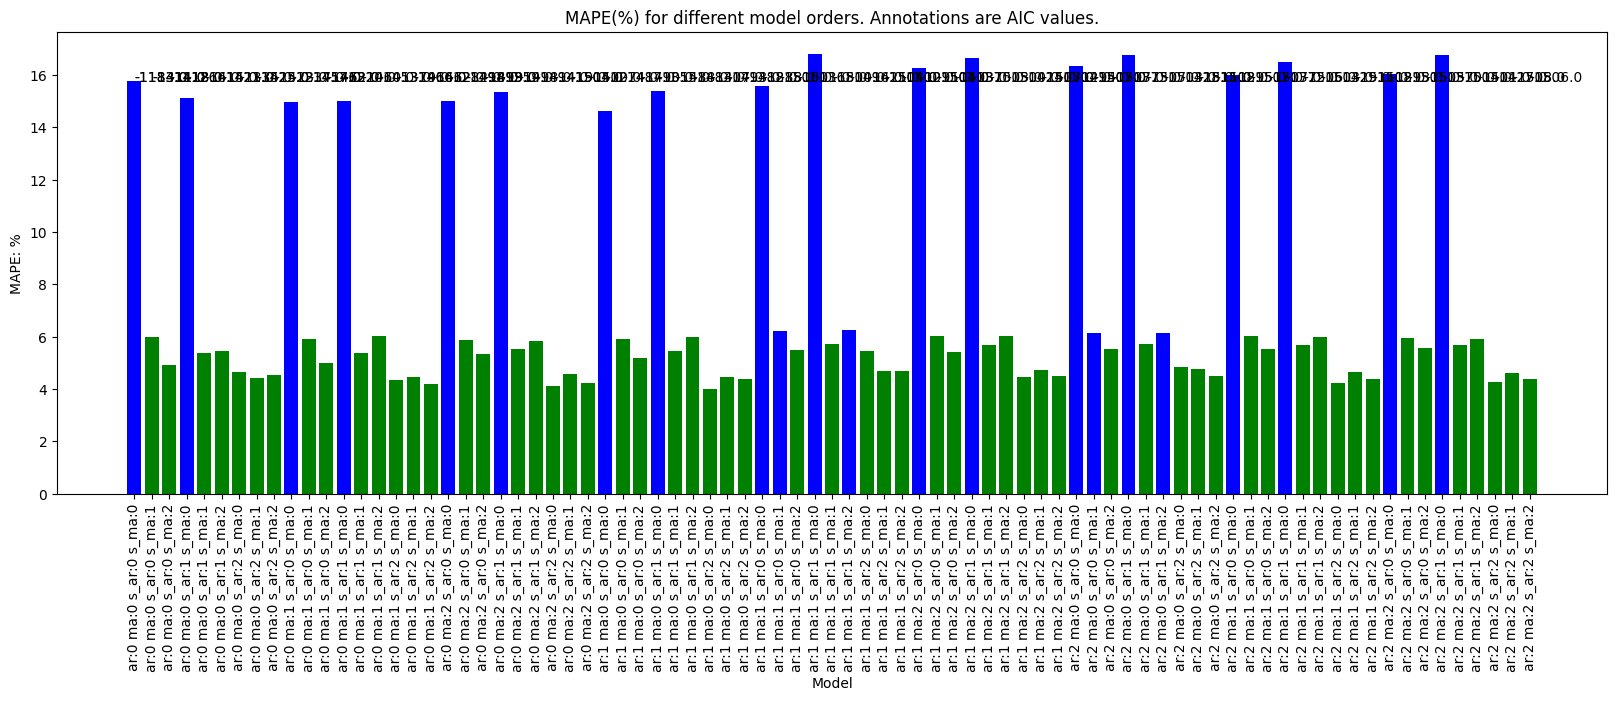

In [114]:
colors = ['g' if x < 6.05 else 'b' for x in model_properties['test_score']]
plt.figure(figsize=(20,6));
plt.bar(model_properties['model_order'],model_properties['test_score'], color= colors);
plt.xlabel('Model');
plt.ylabel('MAPE: %');
plt.title('MAPE(%) for different model orders. Annotations are AIC values.')
for i,aic in enumerate(model_properties['aic']):
    plt.annotate(np.round(aic,0), (model_properties['model_order'][i], model_properties['test_score'][1]));
plt.xticks(rotation=90);

In [116]:
agile_model = SARIMAX(endog=log_transformed_data,order=(1,1,2), seasonal_order=(1,1,2,12),
                                        enforce_invertibility=False).fit(disp=False)
agile_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            IR14200   No. Observations:                  391
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                 756.804
Date:                            Mon, 03 Nov 2025   AIC                          -1499.609
Time:                                    13:34:15   BIC                          -1472.064
Sample:                                         0   HQIC                         -1488.677
                                            - 391                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5505      0.087      6.319      0.000       0.380       0.721
ma.L1         -0.2115      0.098     -2.156      0.031      -0.404      -0.019
ma.L2          0.1533      0.050      3.078      0.002       0.056       0.251
ar.S.L12      -0.5715      7.986     -0.072      0.943     -16.223      15.080
ma.S.L12      -0.4213      8.162     -0.052      0.959     -16.418      15.576
ma.S.L24      -0.5744      7.864     -0.073      0.942     -15.988      14.839
sigma2         0.0010      0.001      1.217      0.224      -0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               175.43
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [119]:
# Forecast for the whole test window using POSITIONS (model has no datetime freq)
start_index = agile_model.nobs                      # first step after training
end_index   = agile_model.nobs + len(test_data) - 1 # last step of test window

agile_model_pred = np.exp(
    agile_model.predict(start=start_index, end=end_index, dynamic=True, typ='levels')
)

# Optional: align index to test dates if you will plot
agile_model_pred.index = test_data.index

print("MAPE:{}%".format(np.round(mean_abs_pct_error(test_data, agile_model_pred), 2)))
print("MAE:{}".format(np.round(mean_absolute_error(test_data, agile_model_pred), 2)))


MAPE:6.02%
MAE:13.24


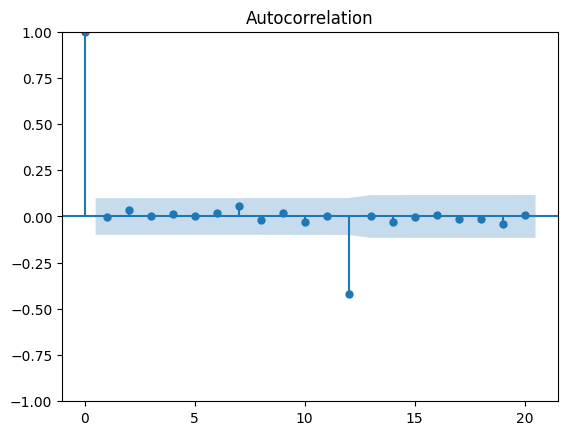

In [120]:
plot_acf(agile_model.resid, lags=20);
